In [116]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer

In [117]:
np.random.seed(42)

def generate_low_rank_data(n_samples, n_features, rank, noise_std=2):
    # Z matrix N(0,I)
    Z = np.random.normal(0, 1, size=(n_samples, rank))
    A = np.random.randn(rank, n_features)

    # Beta Matrix with shape (rank,)
    beta = np.random.randn(rank)

    # θ* = Moore-Penrose inverse of A.beta
    theta_star = np.linalg.pinv(A).dot(beta)

    # X matrix
    X = np.dot(Z, A)  # Dot product of Z and A

    # Generate epsilon from N(0,2)
    epsilon = np.random.normal(0, noise_std, size=n_samples)

    # Generate Y vector Y = X^T θ^* + epsilon
    Y = np.dot(X, theta_star) + epsilon

    return X, Y



# Function of MCAR
def introduce_missingness(X, missing_rate=0.5):
    mask = np.random.rand(*X.shape) < missing_rate
    X_missing = X.copy()
    X_missing[mask] = np.nan
    return X_missing

# Function of missing values
def impute_values(X_missing, strategy='constant'):
    if strategy == 'constant':
        imputer = SimpleImputer(strategy=strategy, fill_value=0)
    elif strategy == 'optimal':
        imputer = SimpleImputer(strategy='mean')
    elif strategy == 'ICE':
        imputer = IterativeImputer(max_iter=1, random_state=0)
    X_imputed = imputer.fit_transform(X_missing)
    return X_imputed

# Risk calculation = E[(Y−f(Ximp​,P))^2]−σ^2
def calculate_risk(Y_true, Y_pred, sigma=2):
    return np.mean((Y_true - Y_pred) ** 2) - 2


# Average SGD
def averaged_sgd(X, Y, gamma, n_epochs=10000, tol=1e-6):
    n_samples, n_features = X.shape
    theta_imp = np.zeros(n_features)
    theta_imp_avg = np.zeros(n_features)
    for epoch in range(n_epochs):
        for t in range(1, n_samples + 1):
            i = np.random.randint(0, n_samples)
            X_i = X[i]
            Y_i = Y[i]
            gradient = X_i * (np.dot(X_i, theta_imp) - Y_i)
            theta_imp -= gamma * gradient
            theta_imp_avg = ((t - 1) * theta_imp_avg + theta_imp) / t
            i = i + 1
            if np.linalg.norm(gamma * gradient) < tol:
                break
    return theta_imp_avg


n_samples = 500
rank = 5
noise_std = 2
n_features_range = [10, 100, 1000, 10000]

# Regularization strength (lambda) =1.2
alpha = 1.2

# Learning rate = 0.00001
gamma = 0.00089



In [ ]:

scaler = StandardScaler()

ridge_risk_results_constant = {}
sgd_risk_results_constant = {}

for n_features in n_features_range:
    # Call Low rank
    X, Y = generate_low_rank_data(n_samples, n_features, rank, noise_std)
    # Call function to impute MCAR
    X_missing = introduce_missingness(X)

    # Zero imputation
    X_imputed = impute_values(X_missing, strategy='constant')

    # Train-test split
    X_train, X_test, Y_train, Y_test = train_test_split(X_imputed, Y, test_size=0.2, random_state=42)

    # Scaling the features
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Ridge Regression
    ridge = Ridge(alpha=alpha)
    ridge.fit(X_train_scaled, Y_train)
    ridge_predictions = ridge.predict(X_test_scaled)
    ridge_risk = calculate_risk(Y_test, ridge_predictions)
    ridge_risk_results_constant[n_features] = ridge_risk

    # Averaged SGD
    theta_estimated = averaged_sgd(X_train_scaled, Y_train, gamma, n_epochs=1000)
    sgd_predictions = X_test_scaled.dot(theta_estimated)
    sgd_risk = calculate_risk(Y_test, sgd_predictions)
    sgd_risk_results_constant[n_features] = sgd_risk


<ipython-input-117-5033bcc439f5>:60: RuntimeWarning: overflow encountered in multiply
  gradient = X_i * (np.dot(X_i, theta_imp) - Y_i)


In [ ]:
ridge_risk_results_optimal = {}
sgd_risk_results_optimal = {}

for n_features in n_features_range:
    # Call low rank function
    X, Y = generate_low_rank_data(n_samples, n_features, rank, noise_std)
    # Call function to impute MCAR
    X_missing = introduce_missingness(X)

    # Impute using Optimal
    X_imputed = impute_values(X_missing, strategy='optimal')

    # Train-test split
    X_train, X_test, Y_train, Y_test = train_test_split(X_imputed, Y, test_size=0.2, random_state=42)

    # Scale the features
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Ridge Regression
    ridge = Ridge(alpha=alpha)
    ridge.fit(X_train_scaled, Y_train)
    ridge_predictions = ridge.predict(X_test_scaled)
    ridge_risk = calculate_risk(Y_test, ridge_predictions)
    ridge_risk_results_optimal[n_features] = ridge_risk

    # Averaged SGD
    theta_estimated = averaged_sgd(X_train_scaled, Y_train, gamma, n_epochs=1000)
    sgd_predictions = X_test_scaled.dot(theta_estimated)
    sgd_risk = calculate_risk(Y_test, sgd_predictions)
    sgd_risk_results_optimal[n_features] = sgd_risk



In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(list(ridge_risk_results_constant.keys()),
         list(ridge_risk_results_constant.values()),
         marker='o', label='Ridge Regression - Zero Imputation')

plt.plot(list(ridge_risk_results_optimal.keys()),
         list(ridge_risk_results_optimal.values()),
         marker='o', label='Ridge Regression - Optimal Imputation')


plt.plot(list(sgd_risk_results_constant.keys()),
         list(sgd_risk_results_constant.values()),
         marker='o', label='Averaged SGD - Zero Imputation')

plt.plot(list(sgd_risk_results_optimal.keys()),
         list(sgd_risk_results_optimal.values()),
         marker='o', label='Averaged SGD - Optimal Imputation')


plt.xscale('log')
plt.yscale('log')
plt.xlabel('Number of features (d)')
plt.ylabel('Risk (Rmis(f) - R?)')
plt.title('Ridge Regression and Averaged SGD with Different Imputation Methods On Low Rank')
plt.grid(True)
plt.legend()
plt.show()


In [79]:
def generate_spiked_data(n_samples, n_features, rank, noise_std=2, spike_std=0.2):
    # low-rank data
    X_low_rank, Y_low_rank = generate_low_rank_data(n_samples, n_features // 2, rank, noise_std)

    #second set of features with low-rank
    Z = np.random.normal(0, 1, size=(n_samples, rank))
    A2 = np.random.randn(n_features // 2, rank)
    X2 = A2.dot(Z.T).T

    # spiked response using the second set of features
    theta_spiked = np.random.normal(0, spike_std, size=n_features // 2)
    Y2 = X2.dot(theta_spiked)

    # Concatenate the low-rank features and spiked features
    X = np.concatenate([X_low_rank, X2], axis=1)
    Y = Y_low_rank + Y2

    return X, Y


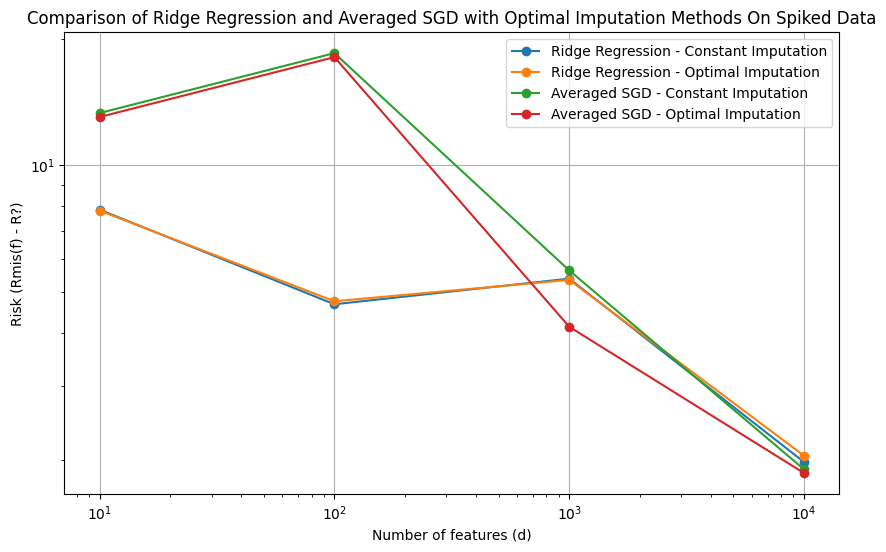

In [81]:
n_samples = 500
rank = 5
noise_std = 2
n_features_range = [10, 100, 1000, 10000]

# Ridge Regression
alpha_base = 1.5  # Base regularization strength (lambda)
alpha_factor = 0.1  # Factor to increase alpha as dimensions increase

# Averaged SGD setup
gamma = 0.00001

ridge_risk_results_constant = {}
ridge_risk_results_optimal = {}
sgd_risk_results_constant = {}
sgd_risk_results_optimal = {}

# Scaling the data
scaler = StandardScaler()

for n_features in n_features_range:

    X, Y = generate_spiked_data(n_samples, n_features, rank, noise_std)
    X_missing = introduce_missingness(X)


    X_imputed = impute_values(X_missing, strategy='constant')

    X_train, X_test, Y_train, Y_test = train_test_split(X_imputed, Y, test_size=0.2, random_state=42)

    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    alpha = alpha_base + alpha_factor * np.log10(n_features)

    # Ridge Regression
    ridge = Ridge(alpha=alpha)
    ridge.fit(X_train_scaled, Y_train)
    ridge_predictions = ridge.predict(X_test_scaled)
    ridge_risk_constant = calculate_risk(Y_test, ridge_predictions)
    ridge_risk_results_constant[n_features] = ridge_risk_constant

    # Averaged SGD
    theta_estimated = averaged_sgd(X_train_scaled, Y_train, gamma, n_epochs=10)
    sgd_predictions = X_test_scaled.dot(theta_estimated)
    sgd_risk_constant = calculate_risk(Y_test, sgd_predictions)
    sgd_risk_results_constant[n_features] = sgd_risk_constant

    X_imputed_optimal = impute_values(X_missing, strategy='optimal')

    X_train_optimal, X_test_optimal, Y_train_optimal, Y_test_optimal = train_test_split(X_imputed_optimal, Y, test_size=0.2, random_state=42)

    X_train_scaled_optimal = scaler.fit_transform(X_train_optimal)
    X_test_scaled_optimal = scaler.transform(X_test_optimal)

    ridge_optimal = Ridge(alpha=alpha)
    ridge_optimal.fit(X_train_scaled_optimal, Y_train_optimal)
    ridge_predictions_optimal = ridge_optimal.predict(X_test_scaled_optimal)
    ridge_risk_optimal = calculate_risk(Y_test_optimal, ridge_predictions_optimal)
    ridge_risk_results_optimal[n_features] = ridge_risk_optimal

    theta_estimated_optimal = averaged_sgd(X_train_scaled_optimal, Y_train_optimal, gamma, n_epochs=10000)
    sgd_predictions_optimal = X_test_scaled_optimal.dot(theta_estimated_optimal)
    sgd_risk_optimal = calculate_risk(Y_test_optimal, sgd_predictions_optimal)
    sgd_risk_results_optimal[n_features] = sgd_risk_optimal

plt.figure(figsize=(10, 6))

plt.plot(list(ridge_risk_results_constant.keys()),
         list(ridge_risk_results_constant.values()),
         marker='o', label='Ridge Regression - Constant Imputation')

plt.plot(list(ridge_risk_results_optimal.keys()),
         list(ridge_risk_results_optimal.values()),
         marker='o', label='Ridge Regression - Optimal Imputation')


plt.plot(list(sgd_risk_results_constant.keys()),
         list(sgd_risk_results_constant.values()),
         marker='o', label='Averaged SGD - Constant Imputation')

plt.plot(list(sgd_risk_results_optimal.keys()),
         list(sgd_risk_results_optimal.values()),
         marker='o', label='Averaged SGD - Optimal Imputation')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Number of features (d)')
plt.ylabel('Risk (Rmis(f) - R?)')
plt.title('Comparison of Ridge Regression and Averaged SGD with Optimal Imputation Methods On Spiked Data')
plt.grid(True)
plt.legend()
plt.show()


In [82]:
def introduce_missingness_mnar(X, alpha):
    n_samples, n_features = X.shape
    mask = np.zeros_like(X, dtype=bool)
    for j in range(n_features):
        prob = 1 / (1 + np.exp(-alpha[j] * X[:, j]))
        mask[:, j] = np.random.rand(n_samples) < prob
    X_missing = X.copy()
    X_missing[mask] = np.nan
    return X_missing

In [83]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from scipy.stats import sem, t


# Function of MNAR setting
def introduce_missingness_mnar(X, alpha):
    n_samples, n_features = X.shape
    mask = np.zeros_like(X, dtype=bool)
    for j in range(n_features):
        prob = 1 / (1 + np.exp(-alpha[j] * X[:, j]))
        mask[:, j] = np.random.rand(n_samples) < prob
    X_missing = X.copy()
    X_missing[mask] = np.nan
    return X_missing


def simulate_and_evaluate_mnar(n_samples, n_features, rank, noise_std, repetitions):
    risks = []

    for _ in range(repetitions):
        X, Y = generate_low_rank_data(n_samples, n_features, rank, noise_std)
        alpha = np.random.uniform(0, 100, size=n_features)
        X_missing = introduce_missingness_mnar(X, alpha)
        X_imputed = impute_values(X_missing)

        X_train, X_test, Y_train, Y_test = train_test_split(X_imputed, Y, test_size=0.2, random_state=42)
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        ridge = Ridge(alpha=1.2)
        ridge.fit(X_train_scaled, Y_train)
        Y_pred = ridge.predict(X_test_scaled)
        mse = mean_squared_error(Y_test, Y_pred)
        risks.append(mse)

    mean_risk = np.mean(risks)
    confidence_interval = sem(risks) * t.ppf((1 + 0.95) / 2., len(risks)-1)

    return mean_risk, confidence_interval

In [92]:
n_samples = 500
rank = 5
noise_std = 2
n_features_range = [10, 100, 1000, 10000]
alpha = 1.2
gamma = 0.00001
ridge_risk_results_zero = {}
sgd_risk_results_zero = {}
ridge_risk_results_optimal = {}
sgd_risk_results_optimal = {}

scaler = StandardScaler()

for n_features in n_features_range:

    X, Y = generate_low_rank_data(n_samples, n_features, rank, noise_std)
    alpha_single = 1.5
    alpha_array = np.full(n_features, alpha_single)
    X_missing_mnar = introduce_missingness_mnar(X, alpha_array)
    X_imputed_zero = impute_values(X_missing_mnar, strategy='constant')
    X_imputed_optimal = impute_values(X_missing_mnar, strategy='optimal')


    X_train_zero, X_test_zero, Y_train_zero, Y_test_zero = train_test_split(X_imputed_zero, Y, test_size=0.2, random_state=42)
    X_train_optimal, X_test_optimal, Y_train_optimal, Y_test_optimal = train_test_split(X_imputed_optimal, Y, test_size=0.2, random_state=42)


    X_train_scaled_zero = scaler.fit_transform(X_train_zero)
    X_test_scaled_zero = scaler.transform(X_test_zero)
    X_train_scaled_optimal = scaler.fit_transform(X_train_optimal)
    X_test_scaled_optimal = scaler.transform(X_test_optimal)


    ridge_zero = Ridge(alpha=alpha_single)
    ridge_zero.fit(X_train_scaled_zero, Y_train_zero)
    ridge_predictions_zero = ridge_zero.predict(X_test_scaled_zero)
    ridge_risk_zero = calculate_risk(Y_test_zero, ridge_predictions_zero)
    ridge_risk_results_zero[n_features] = ridge_risk_zero

    theta_estimated_zero = averaged_sgd(X_train_scaled_zero, Y_train_zero, gamma, n_epochs=10000)
    sgd_predictions_zero = X_test_scaled_zero.dot(theta_estimated_zero)
    sgd_risk_zero = calculate_risk(Y_test_zero, sgd_predictions_zero)
    sgd_risk_results_zero[n_features] = sgd_risk_zero

    ridge_optimal = Ridge(alpha=alpha_single)
    ridge_optimal.fit(X_train_scaled_optimal, Y_train_optimal)
    ridge_predictions_optimal = ridge_optimal.predict(X_test_scaled_optimal)
    ridge_risk_optimal = calculate_risk(Y_test_optimal, ridge_predictions_optimal)
    ridge_risk_results_optimal[n_features] = ridge_risk_optimal

    theta_estimated_optimal = averaged_sgd(X_train_scaled_optimal, Y_train_optimal, gamma, n_epochs=10)
    sgd_predictions_optimal = X_test_scaled_optimal.dot(theta_estimated_optimal)
    sgd_risk_optimal = calculate_risk(Y_test_optimal, sgd_predictions_optimal)
    sgd_risk_results_optimal[n_features] = sgd_risk_optimal

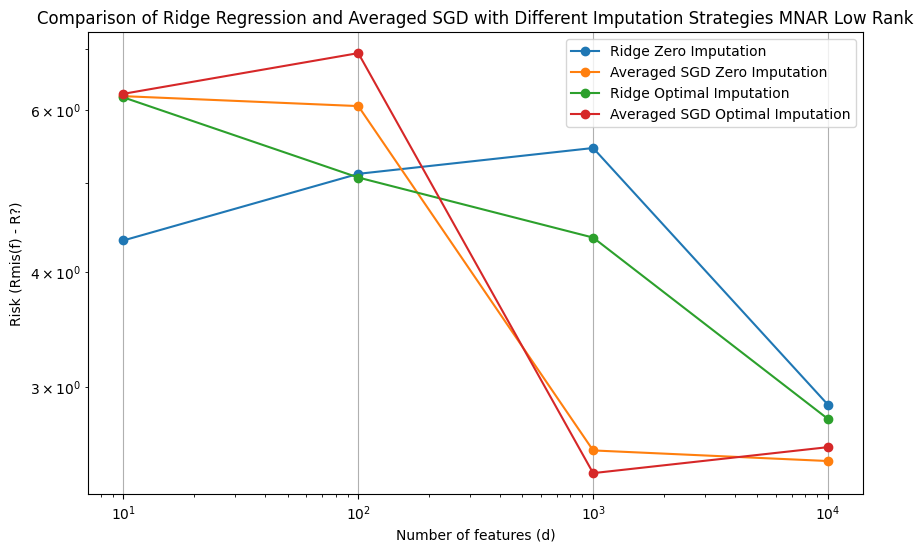

In [93]:
plt.figure(figsize=(10, 6))

plt.plot(list(ridge_risk_results_zero.keys()), list(ridge_risk_results_zero.values()), marker='o', label='Ridge Zero Imputation')

plt.plot(list(sgd_risk_results_zero.keys()), list(sgd_risk_results_zero.values()), marker='o', label='Averaged SGD Zero Imputation')

plt.plot(list(ridge_risk_results_optimal.keys()), list(ridge_risk_results_optimal.values()), marker='o', label='Ridge Optimal Imputation')

plt.plot(list(sgd_risk_results_optimal.keys()), list(sgd_risk_results_optimal.values()), marker='o', label='Averaged SGD Optimal Imputation')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Number of features (d)')
plt.ylabel('Risk (Rmis(f) - R?)')
plt.title('Comparison of Ridge Regression and Averaged SGD with Different Imputation Strategies MNAR Low Rank')
plt.grid(True)
plt.legend()
plt.show()

# Project Part

In [94]:
def minibatch_gradient_descent(X, Y, gamma, batch_size=20, n_epochs=10000, tol=1e-6):
    n_samples, n_features = X.shape
    theta_imp = np.zeros(n_features)
    theta_imp_avg = np.zeros(n_features)
    for epoch in range(n_epochs):
        indices = np.random.choice(n_samples, batch_size, replace=False)
        batch_X = X[indices]
        batch_Y = Y[indices]
        for i in range(batch_size):
            X_i = batch_X[i]
            Y_i = batch_Y[i]
            gradient = X_i * (np.dot(X_i, theta_imp) - Y_i)
            theta_imp -= gamma * gradient
        theta_imp_avg = ((epoch) * theta_imp_avg + theta_imp) / (epoch + 1)
        if np.linalg.norm(gamma * gradient) < tol:
            break
    return theta_imp_avg

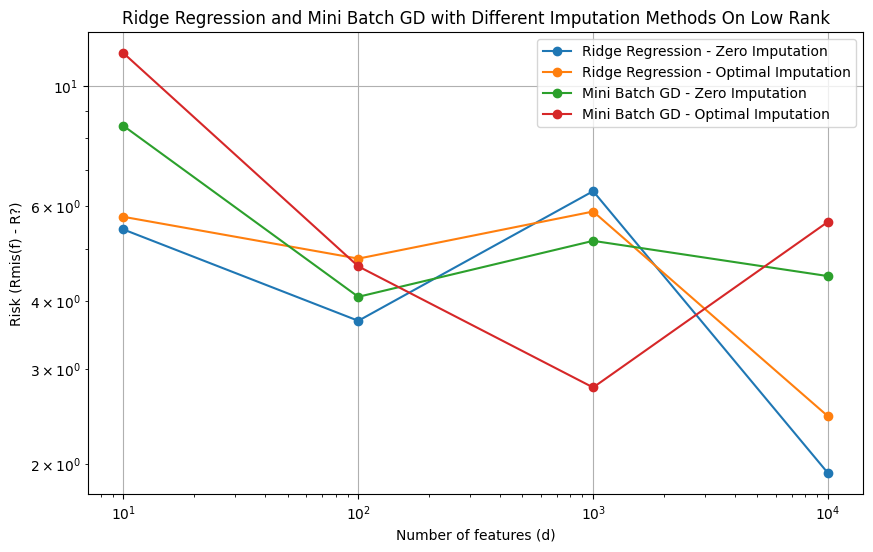

In [104]:

scaler = StandardScaler()

ridge_risk_results_constant = {}
sgd_risk_results_constant = {}

for n_features in n_features_range:
    # Call Low rank
    X, Y = generate_low_rank_data(n_samples, n_features, rank, noise_std)
    # Call function to impute MCAR
    X_missing = introduce_missingness(X)

    # Zero imputation
    X_imputed = impute_values(X_missing, strategy='constant')

    # Train-test split
    X_train, X_test, Y_train, Y_test = train_test_split(X_imputed, Y, test_size=0.2, random_state=42)

    # Scaling the features
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Ridge Regression
    ridge = Ridge(alpha=alpha)
    ridge.fit(X_train_scaled, Y_train)
    ridge_predictions = ridge.predict(X_test_scaled)
    ridge_risk = calculate_risk(Y_test, ridge_predictions)
    ridge_risk_results_constant[n_features] = ridge_risk

    # Mini BatchGD
    theta_estimated = minibatch_gradient_descent(X, Y, gamma, batch_size=20, n_epochs=100, tol=1e-6)
    sgd_predictions = X_test_scaled.dot(theta_estimated)
    sgd_risk = calculate_risk(Y_test, sgd_predictions)
    sgd_risk_results_constant[n_features] = sgd_risk

ridge_risk_results_optimal = {}
sgd_risk_results_optimal = {}

for n_features in n_features_range:
    # Call low rank function
    X, Y = generate_low_rank_data(n_samples, n_features, rank, noise_std)
    # Call function to impute MCAR
    X_missing = introduce_missingness(X)

    # Impute using Optimal
    X_imputed = impute_values(X_missing, strategy='optimal')

    # Train-test split
    X_train, X_test, Y_train, Y_test = train_test_split(X_imputed, Y, test_size=0.2, random_state=42)

    # Scale the features
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Ridge Regression
    ridge = Ridge(alpha=alpha)
    ridge.fit(X_train_scaled, Y_train)
    ridge_predictions = ridge.predict(X_test_scaled)
    ridge_risk = calculate_risk(Y_test, ridge_predictions)
    ridge_risk_results_optimal[n_features] = ridge_risk

    # Mini BatchGD
    theta_estimated = minibatch_gradient_descent(X, Y, gamma, batch_size=20, n_epochs=1000, tol=1e-6)
    sgd_predictions = X_test_scaled.dot(theta_estimated)
    sgd_risk = calculate_risk(Y_test, sgd_predictions)
    sgd_risk_results_optimal[n_features] = sgd_risk


plt.figure(figsize=(10, 6))
plt.plot(list(ridge_risk_results_constant.keys()),
         list(ridge_risk_results_constant.values()),
         marker='o', label='Ridge Regression - Zero Imputation')

plt.plot(list(ridge_risk_results_optimal.keys()),
         list(ridge_risk_results_optimal.values()),
         marker='o', label='Ridge Regression - Optimal Imputation')



plt.plot(list(sgd_risk_results_constant.keys()),
         list(sgd_risk_results_constant.values()),
         marker='o', label='Mini Batch GD - Zero Imputation')

plt.plot(list(sgd_risk_results_optimal.keys()),
         list(sgd_risk_results_optimal.values()),
         marker='o', label='Mini Batch GD - Optimal Imputation')


plt.xscale('log')
plt.yscale('log')
plt.xlabel('Number of features (d)')
plt.ylabel('Risk (Rmis(f) - R?)')
plt.title('Ridge Regression and Mini Batch GD with Different Imputation Methods On Low Rank')
plt.grid(True)
plt.legend()
plt.show()


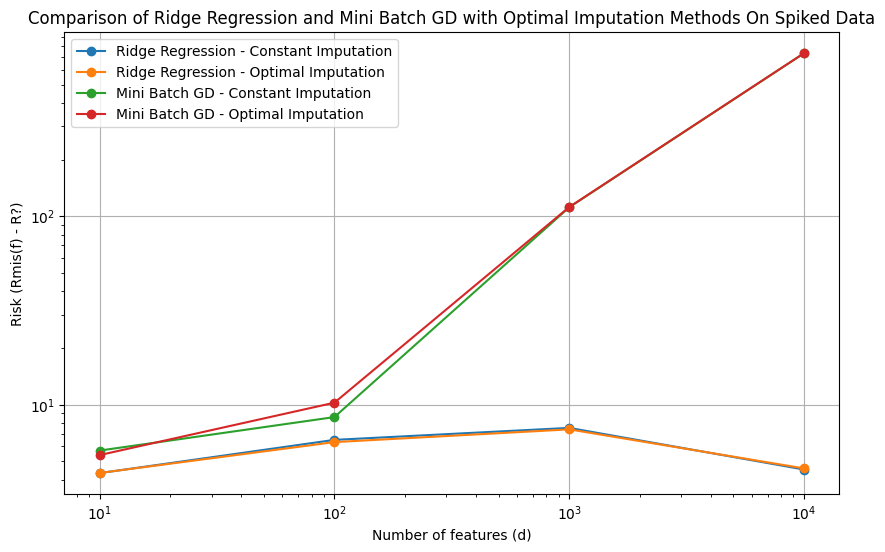

In [111]:
ridge_risk_results_constant = {}
ridge_risk_results_optimal = {}
sgd_risk_results_constant = {}
sgd_risk_results_optimal = {}

scaler = StandardScaler()

for n_features in n_features_range:

    X, Y = generate_spiked_data(n_samples, n_features, rank, noise_std)
    X_missing = introduce_missingness(X)

    X_imputed = impute_values(X_missing, strategy='constant')

    X_train, X_test, Y_train, Y_test = train_test_split(X_imputed, Y, test_size=0.2, random_state=42)

    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    alpha = alpha_base + alpha_factor * np.log10(n_features)

    ridge = Ridge(alpha=alpha)
    ridge.fit(X_train_scaled, Y_train)
    ridge_predictions = ridge.predict(X_test_scaled)
    ridge_risk_constant = calculate_risk(Y_test, ridge_predictions)
    ridge_risk_results_constant[n_features] = ridge_risk_constant


    theta_estimated = minibatch_gradient_descent(X, Y, gamma, batch_size=20, n_epochs=10000, tol=1e-6)
    sgd_predictions = X_test_scaled.dot(theta_estimated)
    sgd_risk_constant = calculate_risk(Y_test, sgd_predictions)
    sgd_risk_results_constant[n_features] = sgd_risk_constant

    X_imputed_optimal = impute_values(X_missing, strategy='optimal')

    X_train_optimal, X_test_optimal, Y_train_optimal, Y_test_optimal = train_test_split(X_imputed_optimal, Y, test_size=0.2, random_state=42)

    X_train_scaled_optimal = scaler.fit_transform(X_train_optimal)
    X_test_scaled_optimal = scaler.transform(X_test_optimal)

    ridge_optimal = Ridge(alpha=alpha)
    ridge_optimal.fit(X_train_scaled_optimal, Y_train_optimal)
    ridge_predictions_optimal = ridge_optimal.predict(X_test_scaled_optimal)
    ridge_risk_optimal = calculate_risk(Y_test_optimal, ridge_predictions_optimal)
    ridge_risk_results_optimal[n_features] = ridge_risk_optimal

    theta_estimated_optimal = minibatch_gradient_descent(X, Y, gamma, batch_size=20, n_epochs=10000, tol=1e-6)
    sgd_predictions_optimal = X_test_scaled_optimal.dot(theta_estimated_optimal)
    sgd_risk_optimal = calculate_risk(Y_test_optimal, sgd_predictions_optimal)
    sgd_risk_results_optimal[n_features] = sgd_risk_optimal


plt.figure(figsize=(10, 6))


plt.plot(list(ridge_risk_results_constant.keys()),
         list(ridge_risk_results_constant.values()),
         marker='o', label='Ridge Regression - Constant Imputation')

plt.plot(list(ridge_risk_results_optimal.keys()),
         list(ridge_risk_results_optimal.values()),
         marker='o', label='Ridge Regression - Optimal Imputation')


plt.plot(list(sgd_risk_results_constant.keys()),
         list(sgd_risk_results_constant.values()),
         marker='o', label='Mini Batch GD - Constant Imputation')

plt.plot(list(sgd_risk_results_optimal.keys()),
         list(sgd_risk_results_optimal.values()),
         marker='o', label='Mini Batch GD - Optimal Imputation')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Number of features (d)')
plt.ylabel('Risk (Rmis(f) - R?)')
plt.title('Comparison of Ridge Regression and Mini Batch GD with Optimal Imputation Methods On Spiked Data')
plt.grid(True)
plt.legend()
plt.show()


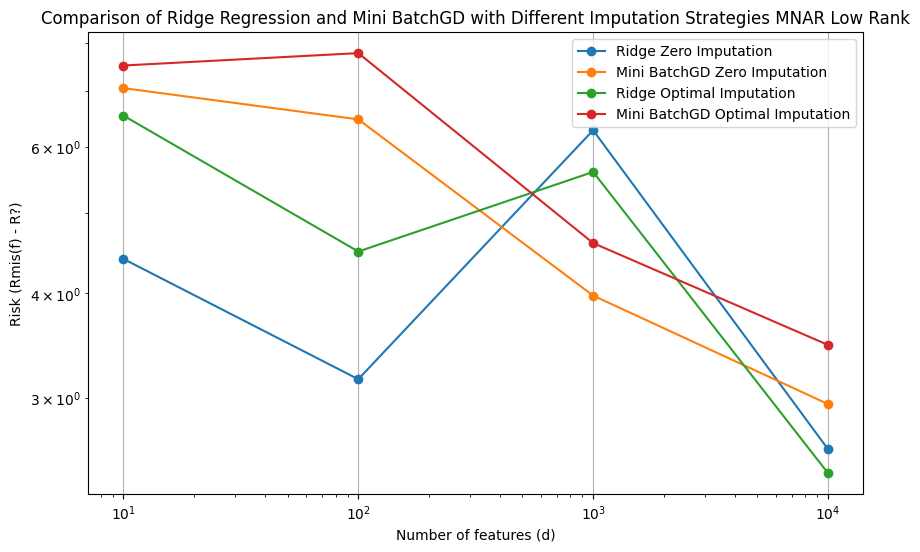

In [115]:
ridge_risk_results_zero = {}
sgd_risk_results_zero = {}
ridge_risk_results_optimal = {}
sgd_risk_results_optimal = {}

scaler = StandardScaler()

for n_features in n_features_range:

    X, Y = generate_low_rank_data(n_samples, n_features, rank, noise_std)
    alpha_single = 1.5
    alpha_array = np.full(n_features, alpha_single)
    X_missing_mnar = introduce_missingness_mnar(X, alpha_array)
    X_imputed_zero = impute_values(X_missing_mnar, strategy='constant')
    X_imputed_optimal = impute_values(X_missing_mnar, strategy='optimal')


    X_train_zero, X_test_zero, Y_train_zero, Y_test_zero = train_test_split(X_imputed_zero, Y, test_size=0.2, random_state=42)
    X_train_optimal, X_test_optimal, Y_train_optimal, Y_test_optimal = train_test_split(X_imputed_optimal, Y, test_size=0.2, random_state=42)

    X_train_scaled_zero = scaler.fit_transform(X_train_zero)
    X_test_scaled_zero = scaler.transform(X_test_zero)
    X_train_scaled_optimal = scaler.fit_transform(X_train_optimal)
    X_test_scaled_optimal = scaler.transform(X_test_optimal)

    ridge_zero = Ridge(alpha=alpha_single)
    ridge_zero.fit(X_train_scaled_zero, Y_train_zero)
    ridge_predictions_zero = ridge_zero.predict(X_test_scaled_zero)
    ridge_risk_zero = calculate_risk(Y_test_zero, ridge_predictions_zero)
    ridge_risk_results_zero[n_features] = ridge_risk_zero

    theta_estimated_zero = minibatch_gradient_descent(X, Y, gamma, batch_size=20, n_epochs=10000, tol=1e-6)
    sgd_predictions_zero = X_test_scaled_zero.dot(theta_estimated_zero)
    sgd_risk_zero = calculate_risk(Y_test_zero, sgd_predictions_zero)
    sgd_risk_results_zero[n_features] = sgd_risk_zero

    ridge_optimal = Ridge(alpha=alpha_single)
    ridge_optimal.fit(X_train_scaled_optimal, Y_train_optimal)
    ridge_predictions_optimal = ridge_optimal.predict(X_test_scaled_optimal)
    ridge_risk_optimal = calculate_risk(Y_test_optimal, ridge_predictions_optimal)
    ridge_risk_results_optimal[n_features] = ridge_risk_optimal


    theta_estimated_optimal = minibatch_gradient_descent(X, Y, gamma, batch_size=20, n_epochs=10000, tol=1e-6)
    sgd_predictions_optimal = X_test_scaled_optimal.dot(theta_estimated_optimal)
    sgd_risk_optimal = calculate_risk(Y_test_optimal, sgd_predictions_optimal)
    sgd_risk_results_optimal[n_features] = sgd_risk_optimal

plt.figure(figsize=(10, 6))

plt.plot(list(ridge_risk_results_zero.keys()), list(ridge_risk_results_zero.values()), marker='o', label='Ridge Zero Imputation')

plt.plot(list(sgd_risk_results_zero.keys()), list(sgd_risk_results_zero.values()), marker='o', label='Mini BatchGD Zero Imputation')

plt.plot(list(ridge_risk_results_optimal.keys()), list(ridge_risk_results_optimal.values()), marker='o', label='Ridge Optimal Imputation')

plt.plot(list(sgd_risk_results_optimal.keys()), list(sgd_risk_results_optimal.values()), marker='o', label='Mini BatchGD Optimal Imputation')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Number of features (d)')
plt.ylabel('Risk (Rmis(f) - R?)')
plt.title('Comparison of Ridge Regression and Mini BatchGD with Different Imputation Strategies MNAR Low Rank')
plt.grid(True)
plt.legend()
plt.show()